  0%|                                                                                                                                                    | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.76it/s]
/tmp/ipykernel_2111476/3580910533.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


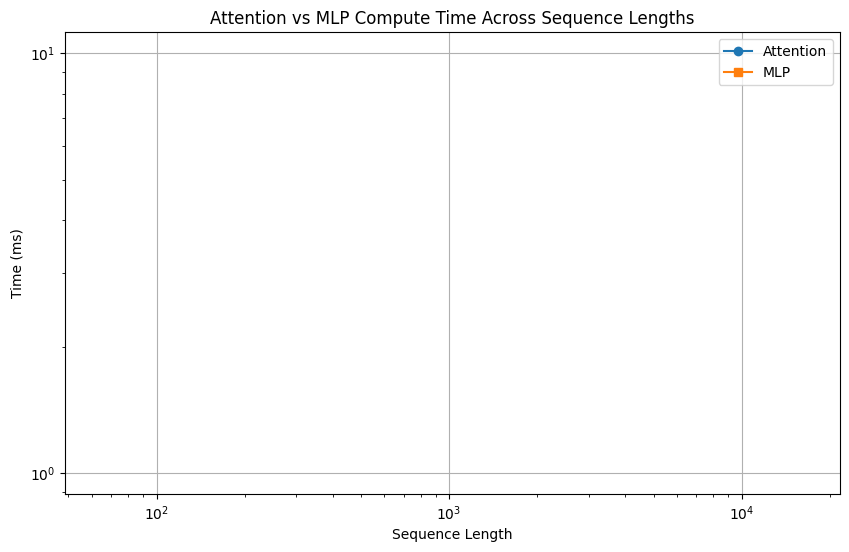


Attention:MLP ratio at each sequence length:


ZeroDivisionError: float division by zero

In [17]:
import os
import sys
os.chdir("/n/home11/tanishqkumar/gravity-chamber/fundamentals/llm")
import torch
from transformer import Transformer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model parameters
vocab_size = 256  # Using a small vocab size for testing
hidden_dim = 512
n_layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model
model = Transformer(depth=n_layers, hidden_dim=hidden_dim, vocab_size=vocab_size, device=device)
model = model.to(device)
model.eval()  # Set to evaluation mode

# Profile inference across sequence lengths
seq_lengths = [64, 256, 512, 1024, 2048, 4096, 8192, 16384]
attn_times = []
mlp_times = []

with torch.no_grad():
    for seq_len in tqdm(seq_lengths):
        batch_size = 1
        x = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)
        
        # Profile with torch profiler
        with torch.profiler.profile(
            activities=[
                torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA,
            ],
            record_shapes=True,
            profile_memory=True,
            with_stack=True
        ) as prof:
            out = model(x)
            
        # Extract attention and MLP times
        events = prof.key_averages()
        attn_time = sum(event.cuda_time_total for event in events if "attn" in str(event.key).lower())
        mlp_time = sum(event.cuda_time_total for event in events if "mlp" in str(event.key).lower())
        
        attn_times.append(attn_time / 1000)  # Convert to ms
        mlp_times.append(mlp_time / 1000)  # Convert to ms

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, attn_times, marker='o', label='Attention')
plt.plot(seq_lengths, mlp_times, marker='s', label='MLP')
plt.xlabel('Sequence Length')
plt.ylabel('Time (ms)')
plt.title('Attention vs MLP Compute Time Across Sequence Lengths')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Print ratio at each sequence length
print("\nAttention:MLP ratio at each sequence length:")
for seq_len, attn, mlp in zip(seq_lengths, attn_times, mlp_times):
    print(f"Sequence length {seq_len:5d}: {attn/mlp:.2f}")


100%|████████████████████████████████████████████| 4/4 [09:02<00:00, 135.59s/it]


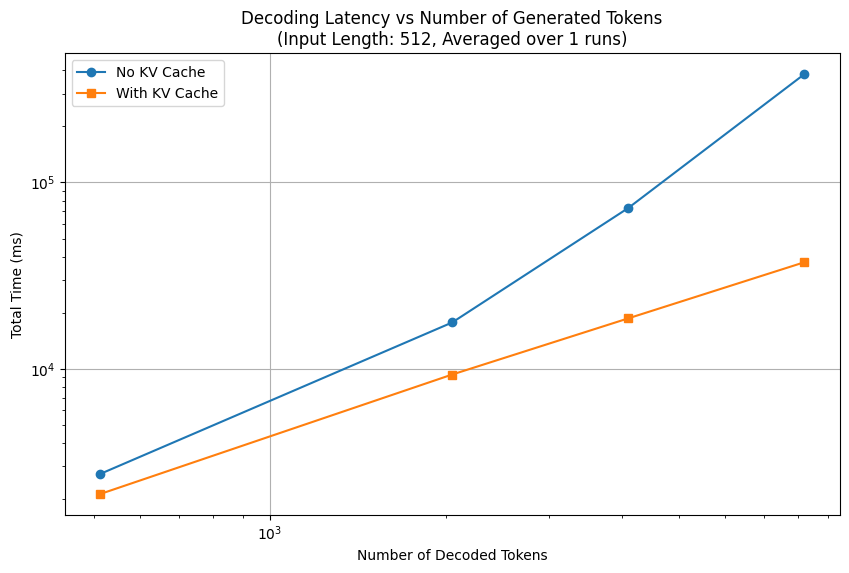


Average time per decoded token (averaged over 1 runs):
----------------------------------------------------
Decoding Method | Tokens Decoded | Avg ms/token
----------------------------------------------------
No KV Cache     |            512 |         5.31
With KV Cache   |            512 |         4.15
----------------------------------------------------
No KV Cache     |           2048 |         8.65
With KV Cache   |           2048 |         4.55
----------------------------------------------------
No KV Cache     |           4096 |        17.80
With KV Cache   |           4096 |         4.55
----------------------------------------------------
No KV Cache     |           8192 |        46.58
With KV Cache   |           8192 |         4.55
----------------------------------------------------


In [1]:
import os
import sys
import time
# Ensure the correct path is used if running interactively or as a script
# Note: os.chdir might not be ideal in all scenarios, consider adding to sys.path instead
# if "/n/home11/tanishqkumar/gravity-chamber/fundamentals/llm" not in sys.path:
#     sys.path.append("/n/home11/tanishqkumar/gravity-chamber/fundamentals/llm")
# For simplicity, keeping os.chdir as in the original selection
try:
    os.chdir("/n/home11/tanishqkumar/gravity-chamber/fundamentals/llm")
except FileNotFoundError:
    print("Warning: Could not change directory. Make sure the path is correct.")
    # Optionally, set a default path or raise an error if the path is critical
    # os.chdir(".") # Example: change to current directory if the target doesn't exist

import torch
from transformer import Transformer
from generation import TransformerGenerator # Import the KV cache generator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Initialize model parameters
vocab_size = 256  # Using a small vocab size for testing
hidden_dim = 512
n_layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model
model = Transformer(depth=n_layers, hidden_dim=hidden_dim, vocab_size=vocab_size, device=device)
model = model.to(device)
model.eval()  # Set to evaluation mode

# Create KV cache generator instance
generator = TransformerGenerator(model)

# Profile decoding across different numbers of tokens to generate
input_seq_len = 512  # Fixed input sequence length
num_decode_tokens = [512, 2048, 4096, 8192]  # Number of tokens to decode
decode_times_no_kv = []
decode_times_kv = []
n_runs = 1

with torch.no_grad():
    for n_tokens in tqdm(num_decode_tokens):
        batch_size = 1
        times_for_this_n_no_kv = []
        times_for_this_n_kv = []

        for _ in range(n_runs):
            # Create input sequence (prompt)
            prompt_tensor = torch.randint(0, vocab_size, (batch_size, input_seq_len)).to(device)
            prompt_list = prompt_tensor.squeeze(0).tolist() # For KV cache generator

            # --- Time the decoding WITHOUT KV Cache ---
            x = prompt_tensor.clone() # Use a copy for the non-KV version
            start_time_no_kv = time.time()
            # Autoregressive decoding (no KV cache)
            for _ in range(n_tokens):
                logits = model(x)  # Get next token logits
                # logits is [B, S, V] from model.unemb, logits[:, -1:] is [B, 1, V]
                next_token = torch.argmax(logits[:, -1:, :], dim=-1)  # [B, 1]
                x = torch.cat([x, next_token], dim=1)  # Append to sequence
            torch.cuda.synchronize()  # Wait for CUDA operations to complete
            end_time_no_kv = time.time()
            times_for_this_n_no_kv.append((end_time_no_kv - start_time_no_kv) * 1000)  # Convert to ms

            # --- Time the decoding WITH KV Cache ---
            start_time_kv = time.time()
            # Autoregressive decoding (with KV cache) using TransformerGenerator
            _ = generator.generate(prompt_list, n_tokens)
            torch.cuda.synchronize() # Wait for CUDA operations to complete
            end_time_kv = time.time()
            times_for_this_n_kv.append((end_time_kv - start_time_kv) * 1000) # Convert to ms

        # Take average across runs
        avg_time_no_kv = np.mean(times_for_this_n_no_kv)
        decode_times_no_kv.append(avg_time_no_kv)
        avg_time_kv = np.mean(times_for_this_n_kv)
        decode_times_kv.append(avg_time_kv)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(num_decode_tokens, decode_times_no_kv, marker='o', label='No KV Cache')
plt.plot(num_decode_tokens, decode_times_kv, marker='s', label='With KV Cache')
plt.xlabel('Number of Decoded Tokens')
plt.ylabel('Total Time (ms)')
plt.title(f'Decoding Latency vs Number of Generated Tokens\n(Input Length: {input_seq_len}, Averaged over {n_runs} runs)')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Print average time per token
print(f"\nAverage time per decoded token (averaged over {n_runs} runs):")
print("----------------------------------------------------")
print("Decoding Method | Tokens Decoded | Avg ms/token")
print("----------------------------------------------------")
for n_tokens, total_time_no_kv, total_time_kv in zip(num_decode_tokens, decode_times_no_kv, decode_times_kv):
    avg_per_token_no_kv = total_time_no_kv / n_tokens if n_tokens > 0 else 0
    avg_per_token_kv = total_time_kv / n_tokens if n_tokens > 0 else 0
    print(f"No KV Cache     | {n_tokens:14d} | {avg_per_token_no_kv:12.2f}")
    print(f"With KV Cache   | {n_tokens:14d} | {avg_per_token_kv:12.2f}")
    print("----------------------------------------------------")


In [2]:
import os
import sys
import time
try:
    os.chdir("/n/home11/tanishqkumar/gravity-chamber/fundamentals/llm")
except FileNotFoundError:
    print("Warning: Could not change directory. Make sure the path is correct.")

import torch
from transformer import Transformer
from generation import TransformerGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

vocab_size = 256
hidden_dim = 512
n_layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model with layer_idx for attention layers
model = Transformer(depth=n_layers, hidden_dim=hidden_dim, vocab_size=vocab_size, device=device) # , gqa=True
model = model.to(device)
model.eval()

# Initialize generator with model
generator = TransformerGenerator(model)

input_seq_len = 512
num_decode_tokens = [256]
n_runs = 20

with torch.no_grad():
    for n_tokens in tqdm(num_decode_tokens):
        batch_size = 1
        times_for_this_n_kv = []

        for _ in range(n_runs):
            # Generate random prompt
            prompt_tensor = torch.randint(0, vocab_size, (batch_size, input_seq_len)).to(device)
            prompt_list = prompt_tensor.squeeze(0).tolist()

            # Time the generation
            start_time_kv = time.time()
            generated = generator.generate(prompt_list, n_tokens)
            torch.cuda.synchronize()
            end_time_kv = time.time()
            times_for_this_n_kv.append((end_time_kv - start_time_kv) * 1000)


        # Calculate and print metrics
        avg_time_kv = np.mean(times_for_this_n_kv)
        tokens_per_sec = n_tokens / (avg_time_kv / 1000)
        print(f"Tokens per second with KV cache: {tokens_per_sec:.2f}")


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.53s/it]

Tokens per second with KV cache: 378.62
